# Combatting Financial Crime - AI Powered Identification of Company Ownership


## Types of Beneficial Owners ; Calculus ; Comments
1. BO with direct ownership interest : **25% or more if the shares or voting rights.** *Direct calculus, max. 4 BOs*.

2. BO with indirect ownership interest : **25% or more if the shares or voting rights through chain of legal entities.** *The indirect ownership shall be calculated by multiplying the shares or voting rights held by the intermediate entities in the chain of entities in which the beneficial owner holds shares or voting rights, and by adding together the results from those various chains*

3. BO with direct control of the corporate or other legal entity, through ownership interest : **50% plus one share or voting rights (control meaning the possibility to exercise significant influence and impose relevant decisions).** *Direct calculus - (here max. 1 BO with control via ownership interest)*

4. BO indirect control of the corporate or other legal entity, through ownership interest : **50% plus one of the shares or voting rights (control meaning the possibility to exercise significant influence and impose relevant decisions).** *ndirect control of a legal entity means control of intermediate legal entities in the ownership structure or in various chains of the ownership structure, where the direct control (50% plus one) is identified on each level of the structure*

5. BO with control of legal entity/ies with direct ownership interest in corporate entity : **if neither the concept of direct or indirect ownership interest (#1 and #2) nor of individual direct or indirect control (#3 and #4) or #6 are applicable.** *Ownership interest of more than 50% in legal entity/ies that have an direct ownership interest of 25% and more in the corporate*

6. BO with ownership interest in the corporate entity that controls the corporate entity : **if neither the concept of direct or indirect ownership interest (#1 and #2) nor of individual direct or indirect control (#3 and #4) or #5 are applicable.** *Ownership interest of 25% or more in the corporate entity that controls more than 50% of the corporate entity*

### Other method for data preprocessing.
- Receive Text data
- apply (?<=owned by\s*).* regex filter
- apply company/people regex filter
- set up python data 
- set up networkx graph structures

## Goal : 
The Goal is to find beneficial owners, through the provided calculus rules. This is to find financial crime. But I think a better wording is to find suspicious corporate structures. Generally Complex structures exist either because the company has very expanded activity and reach or it's made opaque for tax evasion, fraud or crime. So flagging suspicious companies can be interesting. 

In [21]:
import networkx as nx
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import os
import textwrap
import re
from collections import deque

## Types of entities :
In our graph analysis we will distinguish two types of entities : **Companies** and **persons**.  
So we will generate graph with nodes that have either a  **Company** or **person** attribute

Now we extracted the companies and the people , we start building the graph from the text data.

In [2]:
denominations = [
    "GmbH", "UG", "AG", "KGaA", "OHG", "KG", "GbR", "GmbH & Co. KG",
    "e.K.", "eG", "PartG", "Stiftung", "SE", "S.L.U.", "S.L.",
    "S.A.", "SARL", "NV", "BV", "Ltd", "PLC", "S.p.A.", "S.r.l.","Gesellschaft","mbH"
]


### Generalization

In [3]:
def split_companies_to_files(input_file, output_dir="companies"):
    """
    Split text blocks from an input file into separate text files.
    
    Each block is separated by ';'.
    The first line of each block is the company name (used as filename).
    
    Args:
        input_file (str): Path to input text file.
        output_dir (str): Folder to store company text files.
    """
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    with open(input_file, "r", encoding="utf-8") as f:
        text = f.read()

    # Split into blocks by ';'
    blocks = [block.strip() for block in text.split(";") if block.strip()]

    for block in blocks:
        lines = block.splitlines()
        if not lines:
            continue

        # First line = company name
        company_name = lines[0].strip()
        # Sanitize filename (remove illegal characters)
        safe_name = "".join(c for c in company_name if c.isalnum() or c in (" ", "_", "-")).rstrip()
        filename = os.path.join(output_dir, f"{safe_name}.txt")

        # Write block to file
        with open(filename, "w", encoding="utf-8") as out:
            out.write(block)

        print(f"Saved: {filename}")


In [4]:
split_companies_to_files("data.txt", output_dir="companies")

Saved: companies\Cousinvest GmbH.txt
Saved: companies\Pontos Vermögensverwaltung GmbH.txt
Saved: companies\Aurum Private Equity GmbH.txt
Saved: companies\TACK TACK CAPITAL SL.txt
Saved: companies\KnorrBremse AG.txt
Saved: companies\RS Food Invest GmbH.txt
Saved: companies\STBC Capital UG.txt
Saved: companies\Magnascope GmbH.txt
Saved: companies\Schillerstraßen Ventures II GbR.txt


In [29]:
def draw_company_graph0(G, title, node_size=2300, font_size=8, wrap_width=12):
    # Start with spring layout
    pos = nx.spring_layout(G, seed=37)

    # Force the main company node to the center
    main_node = "u0"  # assuming main company is always u0
    if main_node in pos:
        pos[main_node] = (0, 0)

    # Optional: use shell layout for better spacing
    pos = nx.shell_layout(G)

    # Node colors: red = company, blue = person
    color_map = [
        "red" if data.get("node_type") == "company" else "lightblue"
        for _, data in G.nodes(data=True)
    ]

    # Node labels: wrap long names
    labels = {}
    for node, data in G.nodes(data=True):
        name = data.get("name", node)
        wrapped = "\n".join(textwrap.wrap(name, width=wrap_width))
        labels[node] = wrapped

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_color=color_map,
        node_size=node_size,
        edgecolors="black"
    )

    # Draw labels inside nodes
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size, font_color="black")

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrowsize=20)

    # Draw edge labels (ownership weights)
    edge_labels = {(u, v): f"{d['weight']*100:.1f}%" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="green", font_size=9)

    # Legend
    red_patch = mpatches.Patch(color="red", label="Company")
    blue_patch = mpatches.Patch(color="lightblue", label="Person")
    plt.legend(handles=[red_patch, blue_patch], loc="best")

    plt.title(f"{title} Ownership Structure", fontsize=14)
    plt.axis("off")
    plt.show()


In [6]:
def parser(text, denominations):
    lines = [line for line in text.strip().splitlines() if line.strip()]
    main_company = lines[0].strip()

    data = {main_company: {"type": "company", "ownership": [], "control": []}}

    # Stack of (indent_level, parent_entity)
    stack = [(-1, main_company)]

    for line in lines[1:]:
        indent = len(line) - len(line.lstrip())
        line = line.strip()

        # --- Case 1: Ownership ---
        m = re.match(r"(\d+(?:\.\d+)?)%.*?owned.*?by\s+(.+)", line, flags=re.IGNORECASE)
        if m:
            pct, owner_name = m.groups()
            weight = float(pct) / 100
            node_type = "company" if any(k in owner_name for k in denominations) else "person"

            # Pop stack until we find a parent with smaller indent
            while stack and indent <= stack[-1][0]:
                if len(stack) == 1:
                    break
                stack.pop()
            parent = stack[-1][1]

            if parent not in data:
                data[parent] = {"type": "company", "ownership": [], "control": []}
            data[parent]["ownership"].append({
                "owner": owner_name,
                "type": node_type,
                "weight": weight
            })

            if node_type == "company":
                stack.append((indent, owner_name))
            continue

        # --- Case 2: Voting rights ---
        m = re.match(r"(\d+(?:\.\d+)?)%\s+voting rights\s+(.+)", line, flags=re.IGNORECASE)
        if m:
            pct, controller_name = m.groups()
            weight = float(pct) / 100
            node_type = "company" if any(k in controller_name for k in denominations) else "person"

            parent = stack[-1][1]  # still apply voting rights to current parent

            if parent not in data:
                data[parent] = {"type": "company", "ownership": [], "control": []}
            data[parent]["control"].append({
                "controller": controller_name,
                "type": node_type,
                "weight": weight
            })

    return data


In [7]:
##### list of companies parsed for processing
L = []
for fname in os.listdir("companies"):
    path=os.path.join("companies",fname)
    if os.path.isfile(path):
        with open(path,"r",encoding="utf-8") as f :
            text=f.read()
    L.append(parser(text,denominations))


In [8]:
print(json.dumps(L[8], indent=2, ensure_ascii=False)) ## example company

{
  "TACK TACK CAPITAL S.L.": {
    "type": "company",
    "ownership": [
      {
        "owner": "Leah & Chloe S.L.",
        "type": "company",
        "weight": 0.5
      },
      {
        "owner": "Six Pack Capital S.L.",
        "type": "company",
        "weight": 0.49
      },
      {
        "owner": "Juan Pablo Giménez Rosello",
        "type": "person",
        "weight": 0.01
      }
    ],
    "control": []
  },
  "Leah & Chloe S.L.": {
    "type": "company",
    "ownership": [
      {
        "owner": "Carlos Severino Martinez",
        "type": "person",
        "weight": 0.9333
      },
      {
        "owner": "Aserant Global S.L.",
        "type": "company",
        "weight": 0.0667
      }
    ],
    "control": []
  },
  "Aserant Global S.L.": {
    "type": "company",
    "ownership": [
      {
        "owner": "Carlos Severino Martinez",
        "type": "person",
        "weight": 1.0
      }
    ],
    "control": []
  },
  "Six Pack Capital S.L.": {
    "type": "com

In [9]:
def json_to_graph(data: dict):
    """
    Convert JSON ownership data into a NetworkX DiGraph.

    Args:
        data (dict): JSON-like dict with ownership info

    Returns:
        nx.DiGraph: Graph with nodes and edges
    """
    G = nx.DiGraph()
    node_ids = {}  # map names to node IDs

    # Helper to generate unique IDs
    def get_node_id(name):
        if name not in node_ids:
            node_ids[name] = f"u{len(node_ids)}"
        return node_ids[name]

    for company, info in data.items():
        company_id = get_node_id(company)
        G.add_node(company_id,
                   node_type=info.get("type", "company"),
                   name=company,
                   ownership=info.get("ownership", []))  # keep ownership info

        # Add edges
        for ownership in info.get("ownership", []):
            owner_name = ownership.get("owner")
            owner_type = ownership.get("type", "person")
            weight = ownership.get("weight", 0)

            owner_id = get_node_id(owner_name)
            G.add_node(owner_id,
                       node_type=owner_type,
                       name=owner_name)

            # Edge from owner -> company
            G.add_edge(owner_id, company_id,
                       edge_type="Ownership",
                       weight=weight)

    return G


In [10]:
def anonymize_nodes(G, attr="name", new_attr="anonymized"):
    """
    Attach an anonymized version of the 'name' attribute to each node.
    Uses regex to abbreviate names by taking the first letter of each word.
    
    Parameters:
        G (nx.Graph): The graph.
        attr (str): The original node attribute containing the name.
        new_attr (str): The new attribute to store the anonymized name.
    """
    
    for node, data in G.nodes(data=True):
        original = data.get(attr, str(node))
        
        # Find the first letter of each word (alphanumeric words only)
        initials = re.findall(r"\b\w", original)
        
        # Join with ". " and add final "."
        anonymized = ". ".join(initial.upper() for initial in initials) + "."
        
        # Store anonymized name
        G.nodes[node][new_attr] = anonymized

    return G


In [11]:
cgraph=[] ### company graphs
for i in L :
    cgraph.append(json_to_graph(i))


## Rules

In [22]:
# -----------------------------
# Scenario 1: Direct ownership
# -----------------------------
def get_direct_beneficial_owners(G, main_node="u0", threshold=0.25, max_bos=4):
    bos = []
    for u, v, d in G.in_edges(main_node, data=True):
        node_data = G.nodes[u]
        if node_data.get("node_type") != "person":
            continue
        if d.get("weight", 0) >= threshold:
            bos.append({
                "name": node_data.get("name", u),
                "weight": d.get("weight", 0),
                "scenario": 1,
                "control": False
            })
    bos = sorted(bos, key=lambda x: x["weight"], reverse=True)[:max_bos]
    return {"company": G.nodes[main_node].get("name", main_node),
            "beneficial_owners": bos}

# -----------------------------
# Scenario 2: Indirect ownership
# -----------------------------
def get_indirect_beneficial_owners(G, main_node="u0", threshold=0.25, max_bos=4):
    contributions = {}
    for node, data in G.nodes(data=True):
        if data.get("node_type") != "person":
            continue
        # skip direct owners
        if G.has_edge(node, main_node):
            continue
        if nx.has_path(G, node, main_node):
            paths = nx.all_simple_paths(G, node, main_node)
            total_weight = 0.0
            for path in paths:
                w = 1.0
                for u, v in zip(path[:-1], path[1:]):
                    w *= G[u][v].get("weight", 0)
                total_weight += w
            if total_weight >= threshold:
                contributions[node] = {
                    "name": data.get("name", node),
                    "weight": total_weight,
                    "scenario": 2,
                    "control": False
                }
    bos = sorted(contributions.values(), key=lambda x: x["weight"], reverse=True)[:max_bos]
    return {"company": G.nodes[main_node].get("name", main_node),
            "beneficial_owners": bos}

# -----------------------------
# Scenario 3: Direct control (>=50%)
# -----------------------------
def get_direct_control_owners(G, main_node="u0", threshold=0.5, max_bos=1):
    bos = []
    for u, v, d in G.in_edges(main_node, data=True):
        node_data = G.nodes[u]
        if node_data.get("node_type") != "person":
            continue
        if d.get("weight", 0) >= threshold:
            bos.append({
                "name": node_data.get("name", u),
                "weight": d.get("weight", 0),
                "scenario": 3,
                "control": True
            })
    bos = sorted(bos, key=lambda x: x["weight"], reverse=True)[:max_bos]
    return {"company": G.nodes[main_node].get("name", main_node),
            "beneficial_owners": bos}

# -----------------------------
# Scenario 4: Indirect control
# -----------------------------
def get_indirect_control_owners(G, main_node="u0", threshold=0.5, max_bos=1000):
    contributions = {}
    for node, data in G.nodes(data=True):
        if data.get("node_type") != "person":
            continue
        if G.has_edge(node, main_node):
            continue
        if nx.has_path(G, node, main_node):
            paths = nx.all_simple_paths(G, node, main_node)
            total_weight = 0.0
            for path in paths:
                w = 1.0
                for u, v in zip(path[:-1], path[1:]):
                    w *= G[u][v].get("weight", 0)
                total_weight += w
            if total_weight >= threshold:
                contributions[node] = {
                    "name": data.get("name", node),
                    "weight": total_weight,
                    "scenario": 4,
                    "control": True
                }
    bos = sorted(contributions.values(), key=lambda x: x["weight"], reverse=True)[:max_bos]
    return {"company": G.nodes[main_node].get("name", main_node),
            "beneficial_owners": bos}

# -----------------------------
# Scenario 5: BO via controlled entity
# -----------------------------
def scenario5_BO_via_controlled_entity(G, main_node="u0", threshold=0.25, max_bos=1000):
    contributions = {}
    for node, data in G.nodes(data=True):
        if data.get("node_type") != "person":
            continue
        # skip if captured in scenarios 1-4 (or 6)
        captured = data.get("captured_scenarios", [])
        if any(s in [1,2,3,4,6] for s in captured):
            continue
        for _, intermediate, d1 in G.out_edges(node, data=True):
            if G.nodes[intermediate].get("node_type") != "company":
                continue
            if d1.get("weight", 0) <= 0.5:
                continue
            for _, v, d2 in G.out_edges(intermediate, data=True):
                if v == main_node and d2.get("weight", 0) >= threshold:
                    contributions[node] = {
                        "name": data.get("name", node),
                        "weight": d1.get("weight", 0) * d2.get("weight", 0),
                        "scenario": 5,
                        "control": True
                    }
                    break
    bos = sorted(contributions.values(), key=lambda x: x["weight"], reverse=True)[:max_bos]
    return {"company": G.nodes[main_node].get("name", main_node),
            "beneficial_owners": bos}

# -----------------------------
# Scenario 6: BO via entity that controls corporate
# -----------------------------


def scenario6_BO_in_controlling_entity(
    G,
    main_node="u0",
    threshold=0.25,
    control_threshold=0.5,
    max_bos=1000,
    max_depth=10
):
    """
    Find persons who own >= `threshold` in a company that is part of a controlling chain
    to `main_node`. A controlling chain means each company->company edge has weight > control_threshold.

    Returns a dict:
      {
        "company": <name of main_node>,
        "beneficial_owners": [
            {
                "name": <person name>,
                "person_node": <person node id>,
                "direct_ownership": <person -> first_company weight>,
                "effective_interest": <direct_ownership * product_of_control_edges>,
                "scenario": 6,
                "control": True,
                "control_path": [company_node_ids from first_company ... main_node],
                "control_path_names": [company names...],
                "control_edge_weights": [w1, w2, ...]  # weights along the control_path edges
            }, ...
        ]
      }
    """
    def find_control_paths(start_company, target_company, control_thresh, max_depth):
        """BFS for paths start_company -> ... -> target_company following only edges with weight > control_thresh.
           Returns list of (path_list, product_of_weights). Path includes both endpoints.
        """
        results = []
        dq = deque()
        dq.append((start_company, [start_company], 1.0))
        while dq:
            node, path, prod = dq.popleft()
            if len(path) > max_depth:
                continue
            if node == target_company:
                results.append((path, prod))
                continue
            for _, nbr, d in G.out_edges(node, data=True):
                # only follow edges to companies (target is a company node too)
                if G.nodes[nbr].get("node_type") != "company":
                    continue
                w = d.get("weight", 0)
                if w <= control_thresh:
                    continue
                if nbr in path:  # avoid cycles
                    continue
                dq.append((nbr, path + [nbr], prod * w))
        return results

    contributions = {}
    for node, data in G.nodes(data=True):
        if data.get("node_type") != "person":
            continue
        # skip persons already captured in scenarios 1-5
        captured = data.get("captured_scenarios", [])
        if any(s in [1, 2, 3, 4, 5] for s in captured):
            continue

        # examine all person -> company outgoing edges
        for _, first_company, d1 in G.out_edges(node, data=True):
            if G.nodes[first_company].get("node_type") != "company":
                continue
            person_stake = d1.get("weight", 0)
            if person_stake < threshold:
                continue

            # find any controlling chain from the company to the main_node
            paths = find_control_paths(first_company, main_node, control_threshold, max_depth)
            if not paths:
                continue

            # choose the path that gives the maximum product (best indirect link)
            best_path, best_prod = max(paths, key=lambda x: x[1])
            effective_interest = person_stake * best_prod

            # collect edge weights along the control path
            edge_weights = []
            for i in range(len(best_path) - 1):
                edge_data = G.get_edge_data(best_path[i], best_path[i + 1], default={})
                edge_weights.append(edge_data.get("weight", 0))

            contributions[node] = {
                "name": data.get("name", node),
                "person_node": node,
                "direct_ownership": person_stake,
                "effective_interest": effective_interest,
                "scenario": 6,
                "control": True,
                "control_path": best_path,  # company node ids from first_company ... main_node
                "control_path_names": [G.nodes[n].get("name", n) for n in best_path],
                "control_edge_weights": edge_weights
            }

    # sort results: you can choose to sort by direct_ownership or effective_interest.
    bos = sorted(
        contributions.values(),
        key=lambda x: x["direct_ownership"],
        reverse=True
    )[:max_bos]

    return {
        "company": G.nodes[main_node].get("name", main_node),
        "beneficial_owners": bos
    }



In [23]:
def annotate_graph_with_scenarios(G, main_node="u0", thresholds=None, max_bos=None, verbose=True):
    """
    Run all 6 ownership/control scenarios on a company graph and annotate nodes.
    
    Args:
        G (nx.DiGraph): The ownership graph
        main_node (str): Node ID of the main company (default u0)
        thresholds (dict): scenario-specific thresholds, e.g., {1:0.25, 3:0.5, ...}
        max_bos (dict): scenario-specific max BOs
        verbose (bool): If True, print identified beneficial owners per scenario
    """
    if thresholds is None:
        thresholds = {1:0.25, 2:0.25, 3:0.5, 4:0.5, 5:0.25, 6:0.25}
    if max_bos is None:
        max_bos = {1:4, 2:4, 3:1, 4:1000, 5:1000, 6:1000}

    # Initialize attributes
    for node in G.nodes:
        G.nodes[node]["captured_scenarios"] = []
        G.nodes[node]["in_control"] = False
        G.nodes[node]["effective_ownership"] = 0.0

    # List of scenario functions in order
    scenario_funcs = [
        get_direct_beneficial_owners,
        get_indirect_beneficial_owners,
        get_direct_control_owners,
        get_indirect_control_owners,
        scenario5_BO_via_controlled_entity,
        scenario6_BO_in_controlling_entity
    ]

    for i, func in enumerate(scenario_funcs, start=1):
        result = func(
            G,
            main_node=main_node,
            threshold=thresholds.get(i, 0.25),
            max_bos=max_bos.get(i, 1000)
        )
        
        bo_list = result.get("beneficial_owners", [])
        
        # Annotate nodes in the graph
        for bo in bo_list:
            node_name = bo["name"]
            node_id = next((n for n, d in G.nodes(data=True) if d.get("name") == node_name), None)
            if node_id is None:
                continue
            if i not in G.nodes[node_id]["captured_scenarios"]:
                G.nodes[node_id]["captured_scenarios"].append(i)
            if bo.get("control", True):
                G.nodes[node_id]["in_control"] = True
            G.nodes[node_id]["effective_ownership"] = bo.get("weight", 0.0)
        
        # Print summary per scenario
        if verbose:
            print(f"\n=== Scenario {i} ===")
            if not bo_list:
                print("No beneficial owners or control identified.")
            else:
                for bo in bo_list:
                    name = bo["name"]
                    weight = bo.get("weight", 0.0) * 100
                    control = bo.get("control", True)
                    print(f"{name}: Ownership={weight:.2f}%, Control={control}")


In [24]:
for G in cgraph:
    annotate_graph_with_scenarios(G, main_node="u0")
    anonymize_nodes(G)
    set_company_levels(G, root="u0")



=== Scenario 1 ===
No beneficial owners or control identified.

=== Scenario 2 ===
JörgUwe Goldbeck: Ownership=34.40%, Control=False
Jan Hendrik Goldbeck: Ownership=34.40%, Control=False
Joachim Goldbeck: Ownership=29.10%, Control=False

=== Scenario 3 ===
No beneficial owners or control identified.

=== Scenario 4 ===
No beneficial owners or control identified.

=== Scenario 5 ===
No beneficial owners or control identified.

=== Scenario 6 ===
No beneficial owners or control identified.

=== Scenario 1 ===
Leopold Schoeller: Ownership=25.00%, Control=False
Milana Schoeller: Ownership=25.00%, Control=False
Helena Schoeller: Ownership=25.00%, Control=False

=== Scenario 2 ===
Alexander Schoeller: Ownership=25.00%, Control=False

=== Scenario 3 ===
No beneficial owners or control identified.

=== Scenario 4 ===
No beneficial owners or control identified.

=== Scenario 5 ===
No beneficial owners or control identified.

=== Scenario 6 ===
No beneficial owners or control identified.

=== S

In [25]:
def draw_company_graph(G, title, node_size=2300, font_size=8, wrap_width=12,filename=None): 
    plt.figure(figsize=(14,14)) 
    # Start with spring layout 
    pos = nx.spring_layout(G, seed=37) 
    # Force the main company node to the center 
    main_node = "u0" 
    if main_node in pos: pos[main_node] = (0, 0) 
    # Optional: shell layout for spacing 
    pos = nx.shell_layout(G) # Define fixed color mapping for scenarios 
    scenario_colors = { 1: "orange", 2: "yellow", 3: "green", 4: "cyan", 5: "magenta", 6: "purple" } 
    # Determine node colors 
    color_map = [] 
    for node, data in G.nodes(data=True): 
        if data.get("node_type") == "company": 
            color_map.append("red") 
        elif data.get("node_type") == "person": 
            scenarios = data.get("captured_scenarios", []) 
            if scenarios: 
                # Pick the lowest scenario number for coloring 
                scenario = max(scenarios) 
                color_map.append(scenario_colors.get(scenario, "lightblue")) 
            else: 
                color_map.append("lightblue") 
            # Non-BO 
        else: 
            color_map.append("gray") 
    # Wrap node labels 
    labels = {} 
    for node, data in G.nodes(data=True): 
        name = data.get("anonymized", node) 
        wrapped = "\n".join(textwrap.wrap(name, width=wrap_width)) 
        labels[node] = wrapped 
    # Draw nodes 
    nx.draw_networkx_nodes( G, pos, node_color=color_map, node_size=node_size, edgecolors="black" ) 
    # Draw labels 
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size, font_color="black") 
    # Draw edges 
    nx.draw_networkx_edges(G, pos,arrows=True, arrowsize=20,min_source_margin=15,min_target_margin=15) 
    # Highlight target company u0 with a thick border 
    nx.draw_networkx_nodes( G, pos, nodelist=["u0"], node_size=2300, node_color="red", edgecolors="black", linewidths=3.5) 
    # Draw edge labels 
    edge_labels = {(u, v): f"{d['weight']*100:.1f}%" for u, v, d in G.edges(data=True)} 
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="green", font_size=9) 
    # Mapping for scenario descriptions 
    scenario_mapping = {1: "Direct Ownership Interest", 
                        2: "Indirect Ownership Interest", 
                        3: "Direct Control Interest", 
                        4: "Indirect Control Interest", 
                        5: "Direct Control of Legal entity in Direct Ownership", 
                        6: "Ownership Interest in the Corporate Entity that Controls " } 
    # Create legend for company, person, and BO scenarios 
    legend_handles = [ mpatches.Patch(color="red", label="Company"), mpatches.Patch(color="lightblue", label="Person (non-BO)") ] 
    # Add BO scenarios with descriptive names 
    for scen, color in scenario_colors.items(): 
        label = scenario_mapping.get(scen, f"BO Scenario {scen}") 
        # fallback if unmapped 
        legend_handles.append(mpatches.Patch(color=color, label=label)) 
    # Place legend outside top-right 
    plt.legend(handles=legend_handles, loc="upper left",  bbox_to_anchor=(1, 1),frameon=True) 
    plt.title(f"{title} Ownership Structure", fontsize=14) 
    plt.axis("off") 
    if filename: 
        plt.savefig(filename, bbox_inches="tight", dpi=150) 
    plt.show() 
    plt.close()

In [26]:
cgraph[4].nodes(data=True)

NodeDataView({'u0': {'node_type': 'company', 'name': 'Pontos Vermögensverwaltung GmbH', 'ownership': [{'owner': 'Dr. Martin Hintze', 'type': 'person', 'weight': 0.6}, {'owner': 'Ebba Pauline Hintze', 'type': 'person', 'weight': 0.2}, {'owner': 'Alexander Benjamin Hintze', 'type': 'person', 'weight': 0.2}], 'captured_scenarios': [], 'in_control': False, 'effective_ownership': 0.0, 'anonymized': 'P. V. G.', 'level': 0}, 'u1': {'node_type': 'person', 'name': 'Dr. Martin Hintze', 'captured_scenarios': [1, 3], 'in_control': True, 'effective_ownership': 0.6, 'anonymized': 'D. M. H.', 'level': 1, 'BO_scenario': None}, 'u2': {'node_type': 'person', 'name': 'Ebba Pauline Hintze', 'captured_scenarios': [], 'in_control': False, 'effective_ownership': 0.0, 'anonymized': 'E. P. H.', 'level': 1, 'BO_scenario': None}, 'u3': {'node_type': 'person', 'name': 'Alexander Benjamin Hintze', 'captured_scenarios': [], 'in_control': False, 'effective_ownership': 0.0, 'anonymized': 'A. B. H.', 'level': 1, 'BO_s

In [27]:
# Automatically assign BO_scenario for all nodes
for G in cgraph :
    for node, data in G.nodes(data=True):
        # Skip companies
        if data.get("node_type") == "company":
            continue

        # Check if node is marked as a beneficial owner
        # Suppose you have annotated nodes like: data['BO'] = True and data['scenario'] = X
        scenario = data.get("scenario", None)
        if scenario in [1, 2, 3, 4, 5, 6]:
            data["BO_scenario"] = scenario
        else:
            # Non-BO persons will not have BO_scenario
            data["BO_scenario"] = None


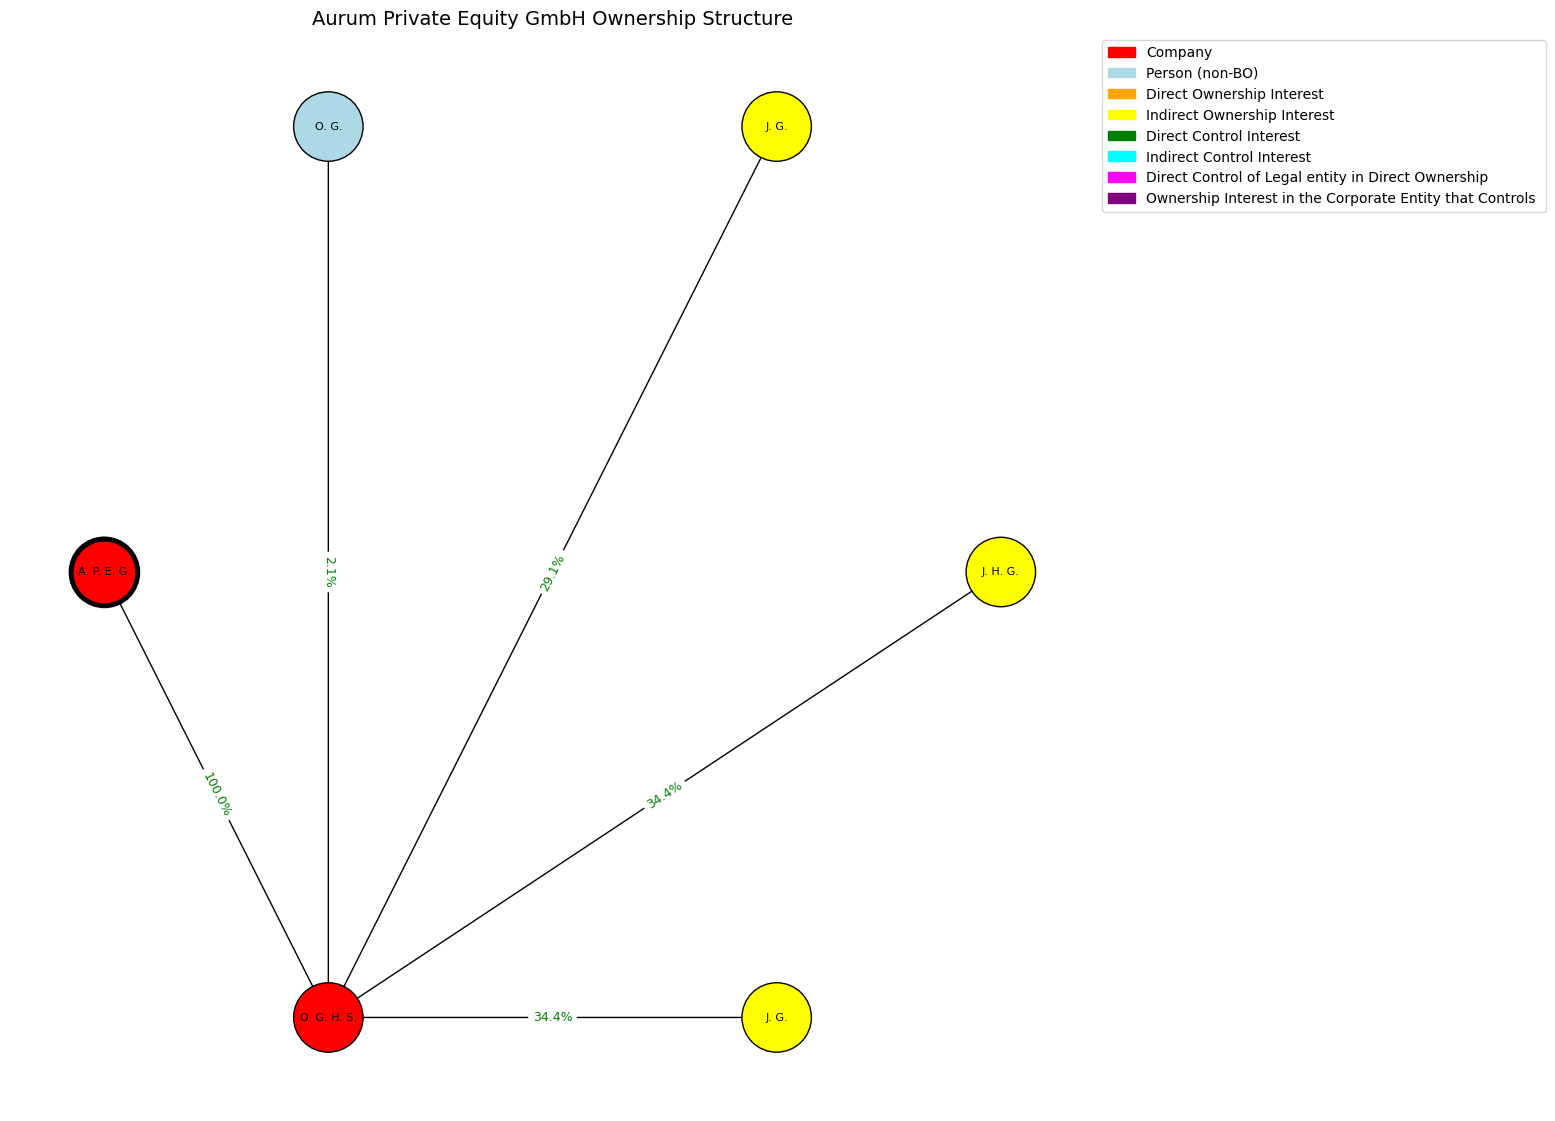

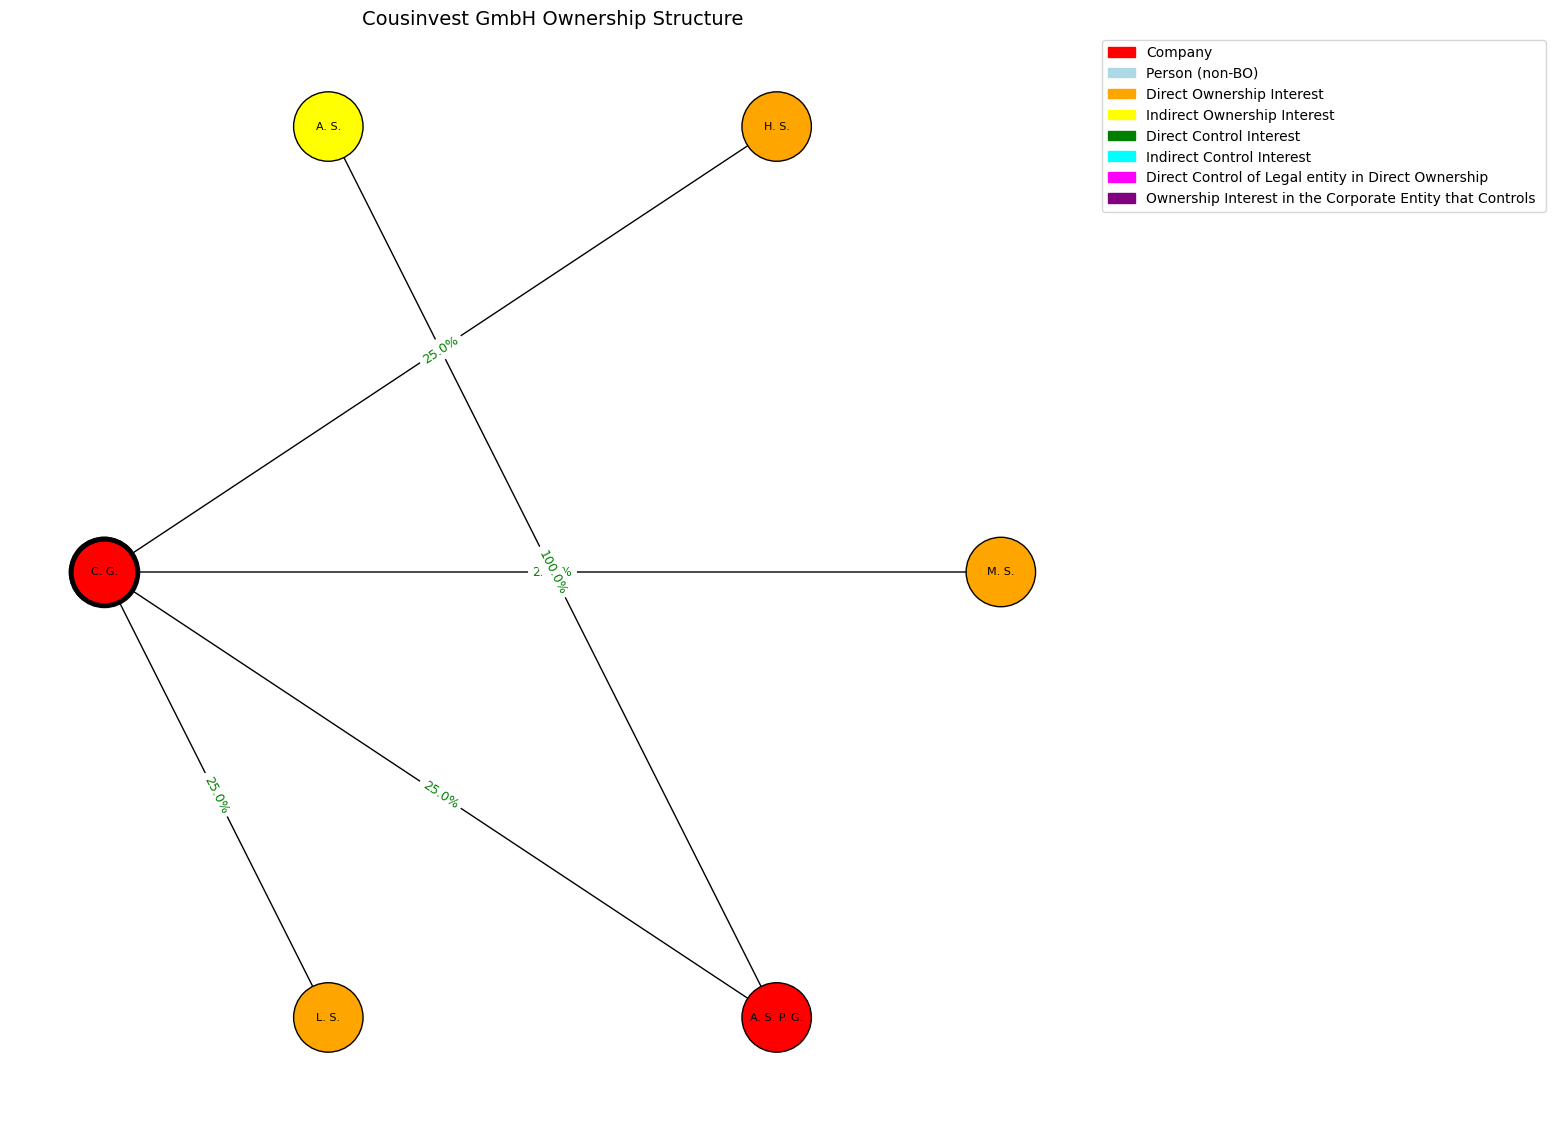

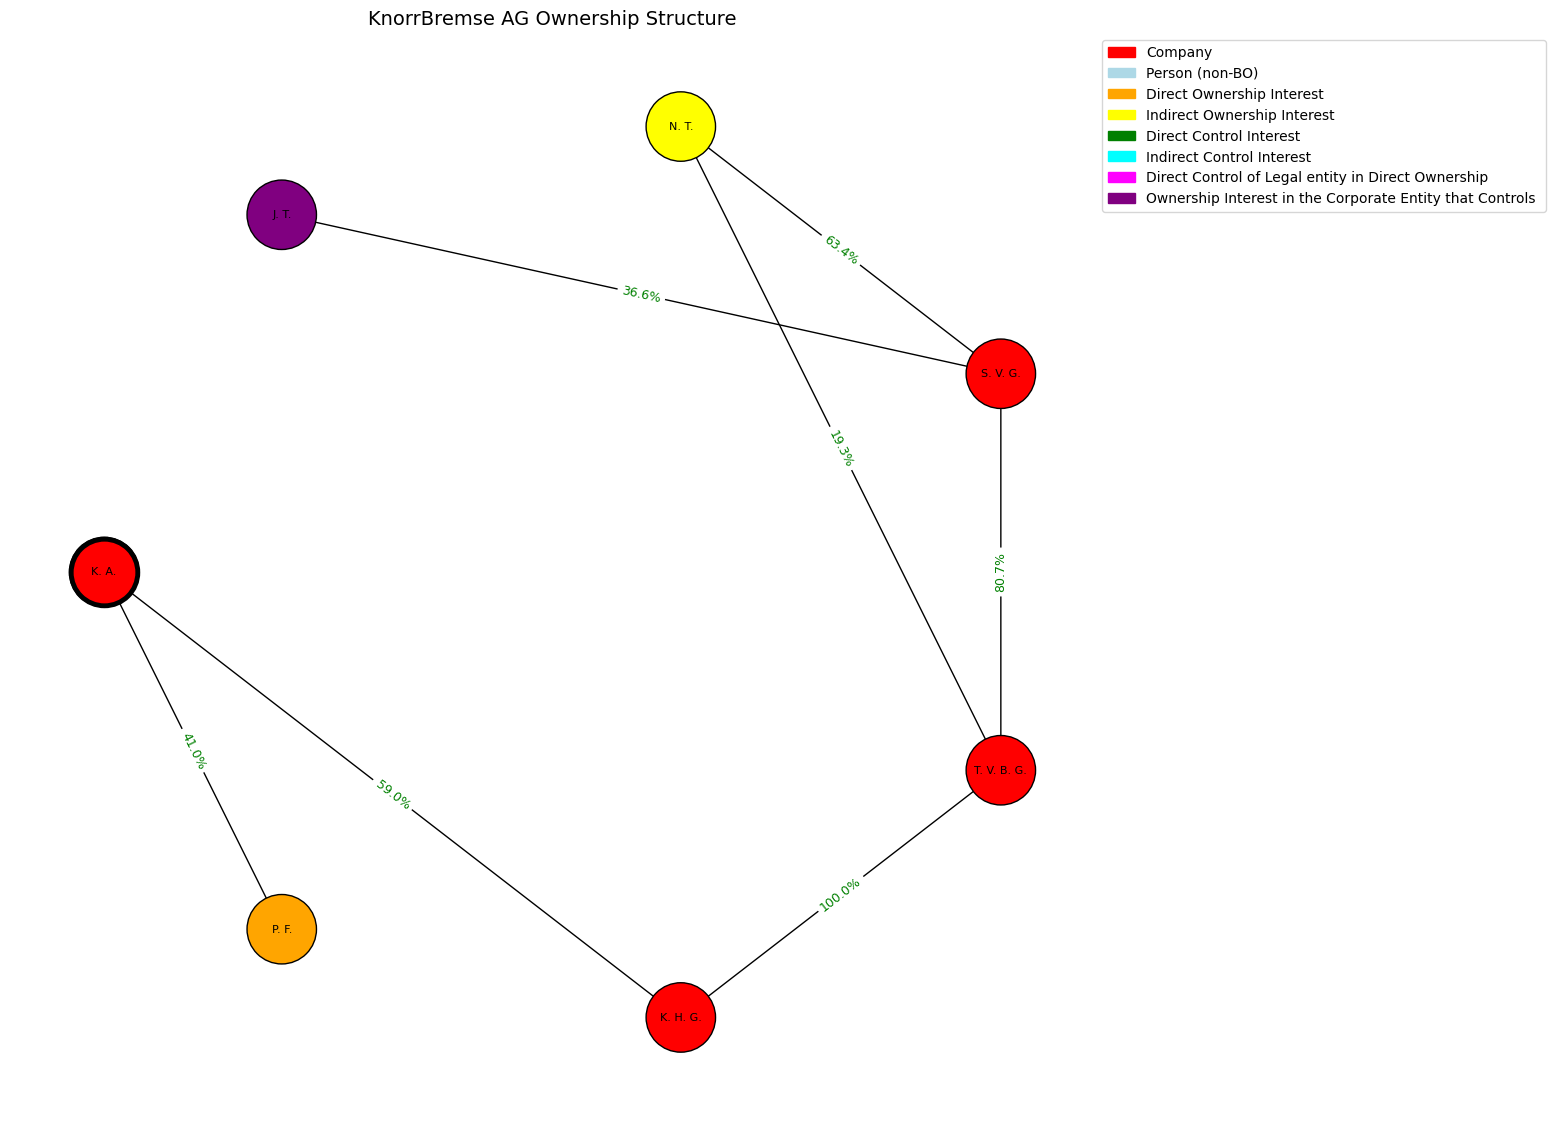

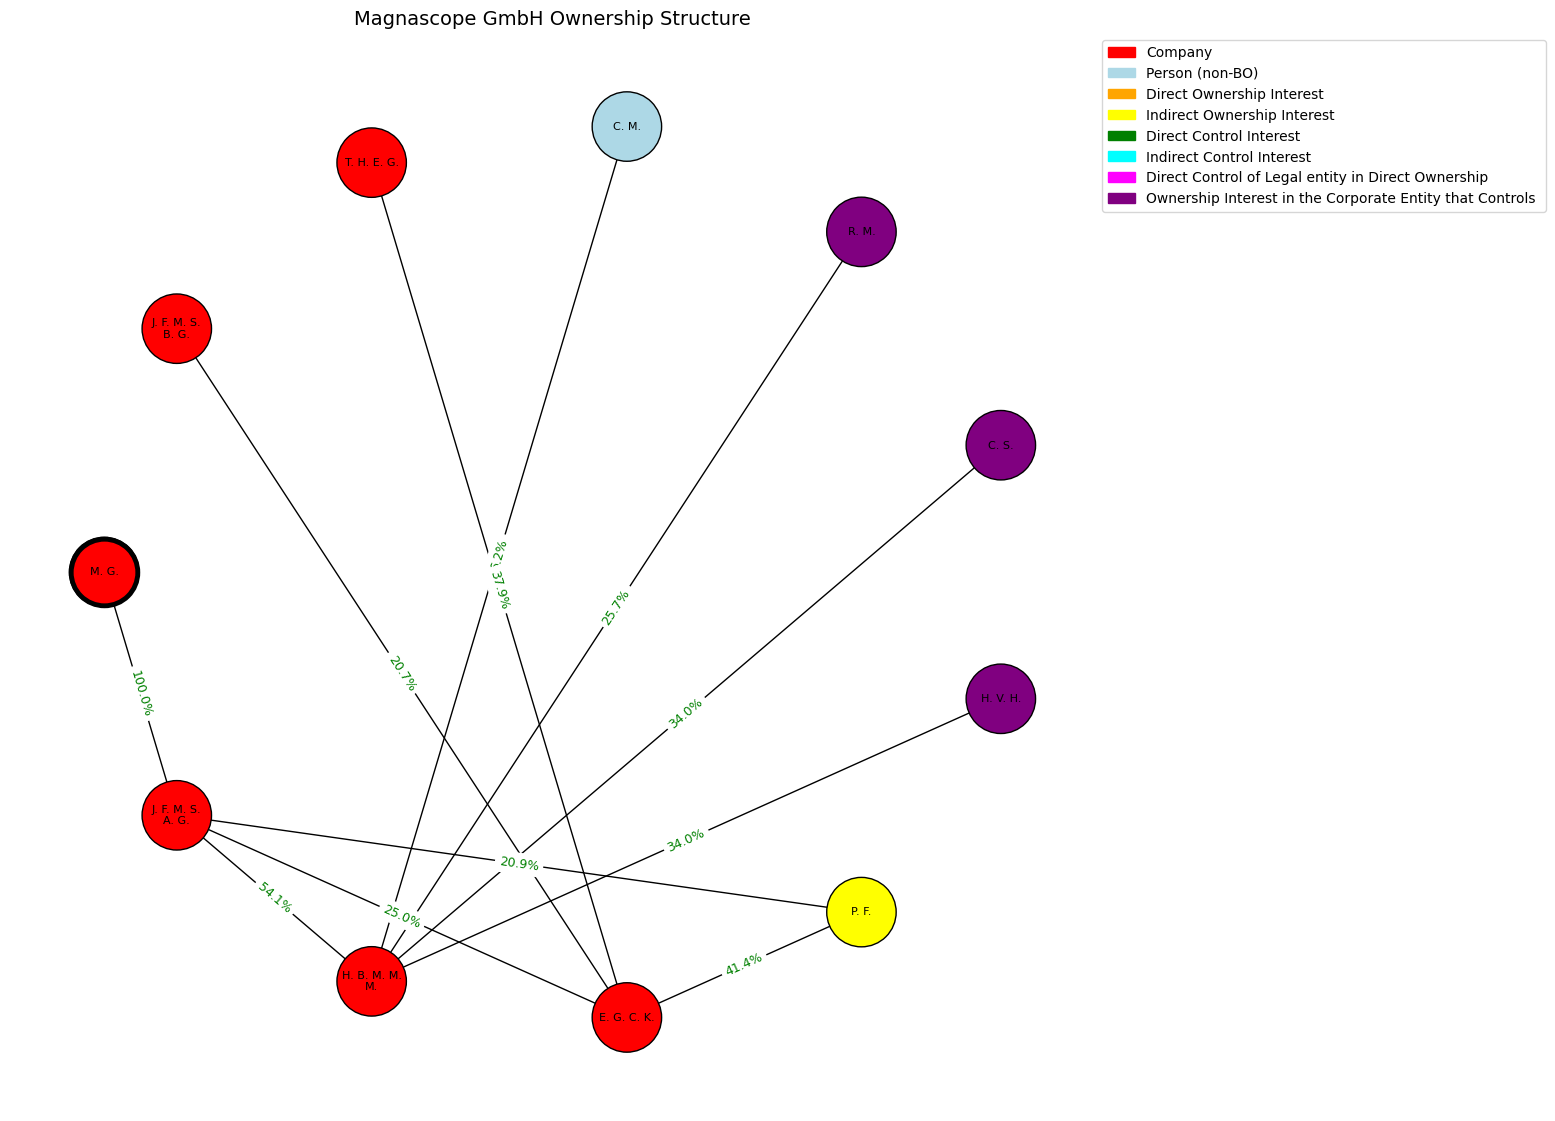

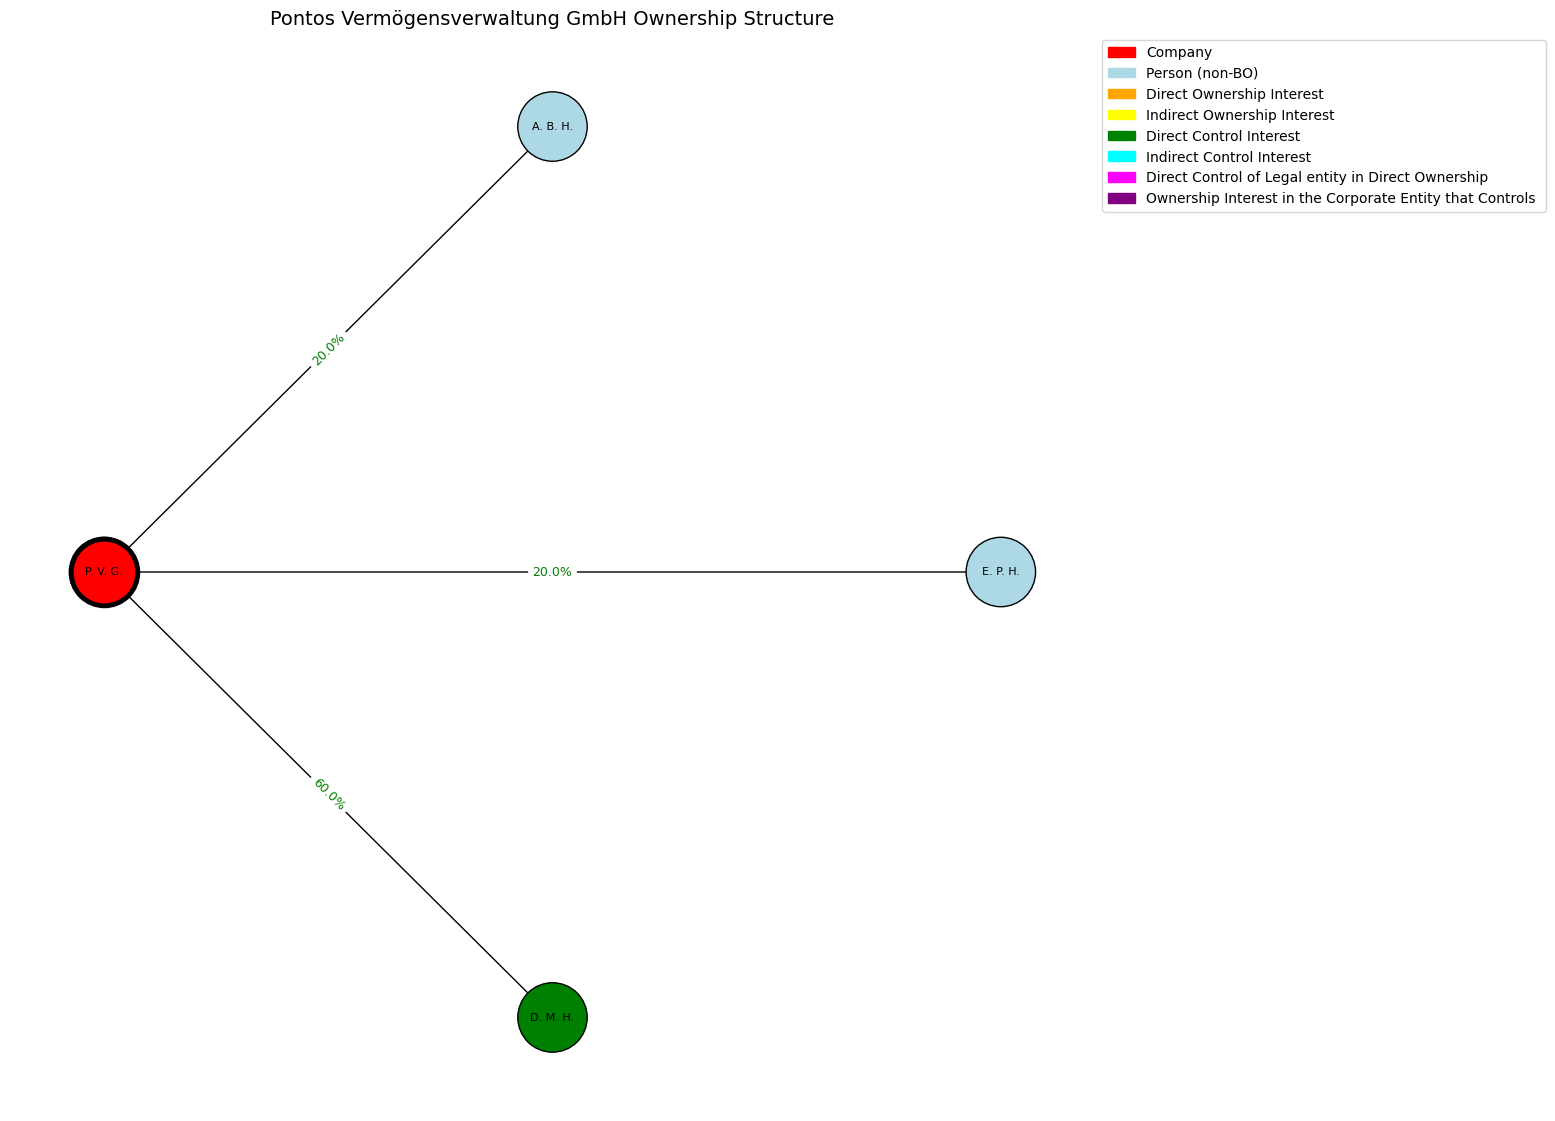

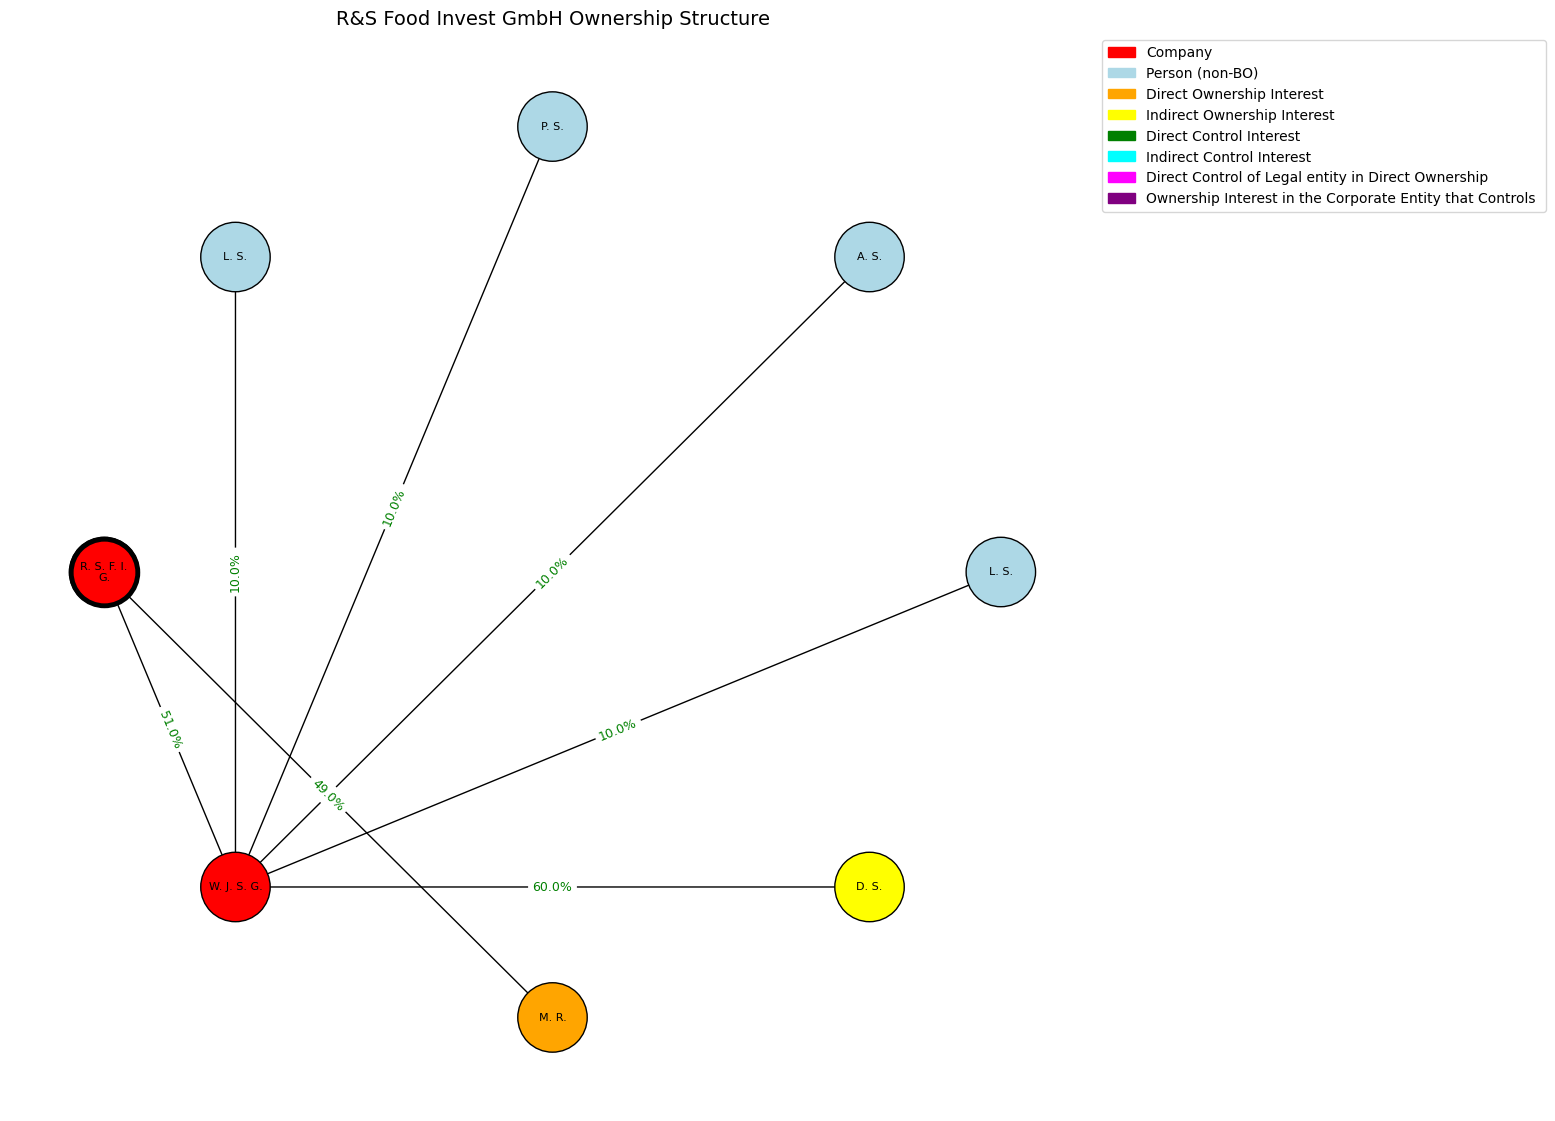

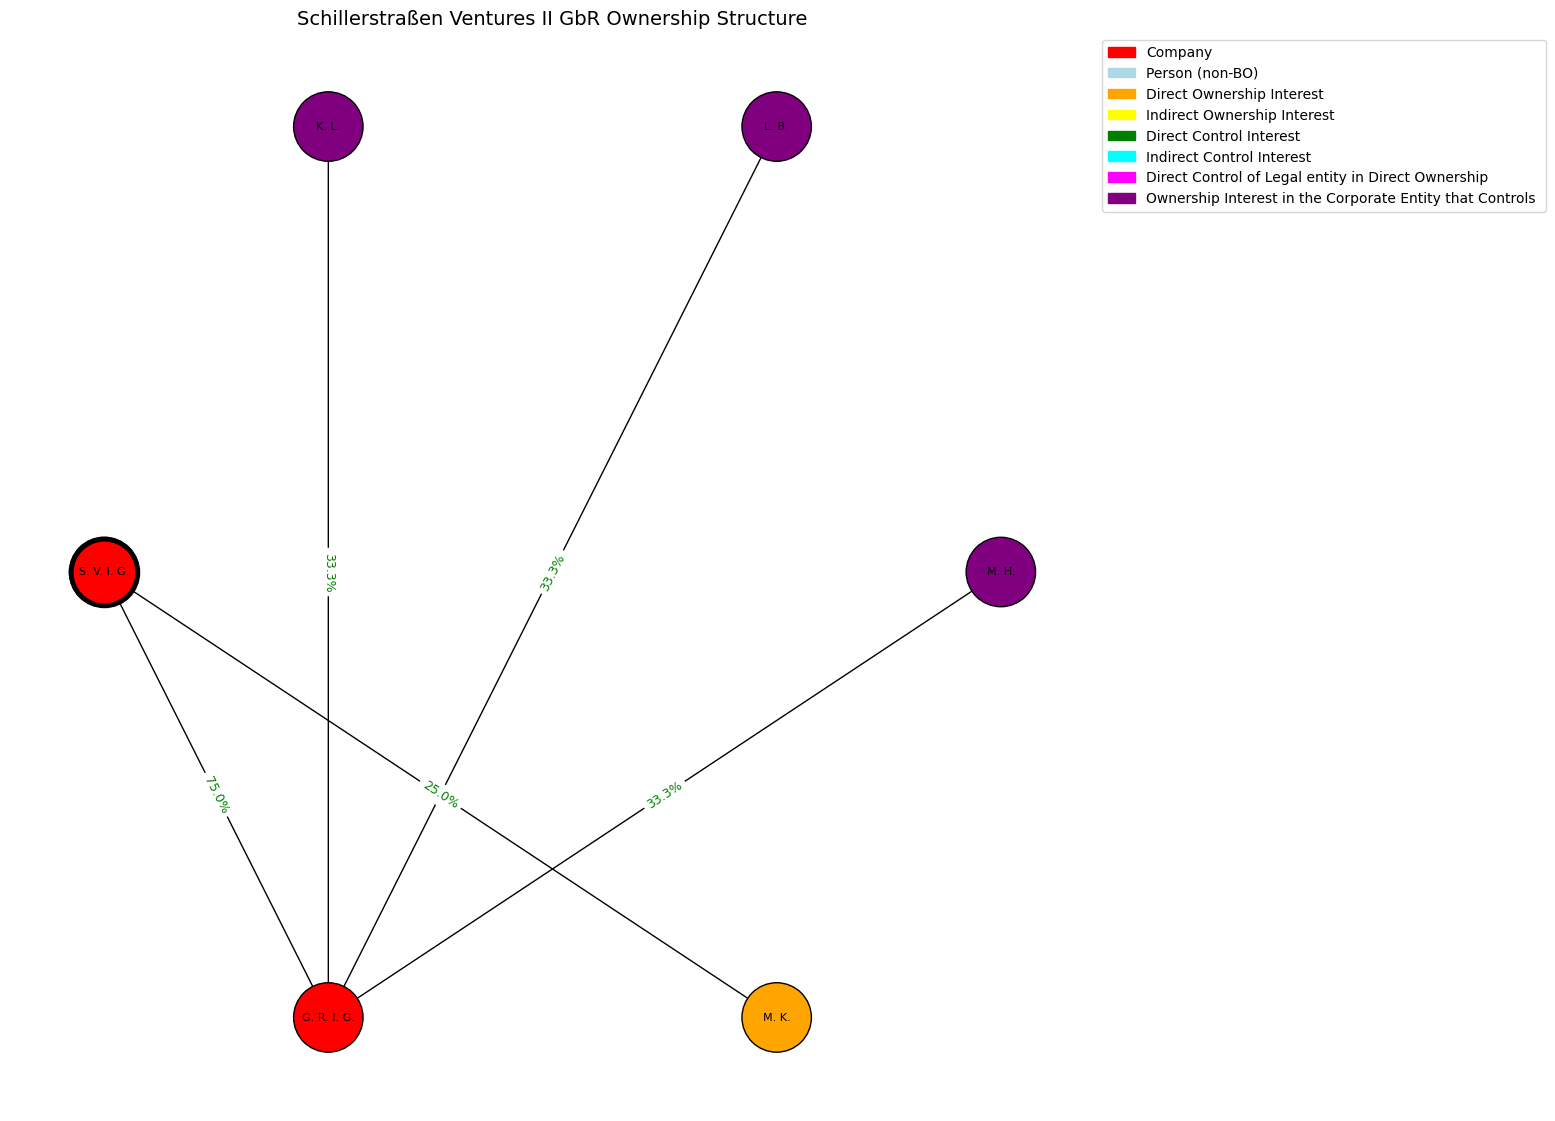

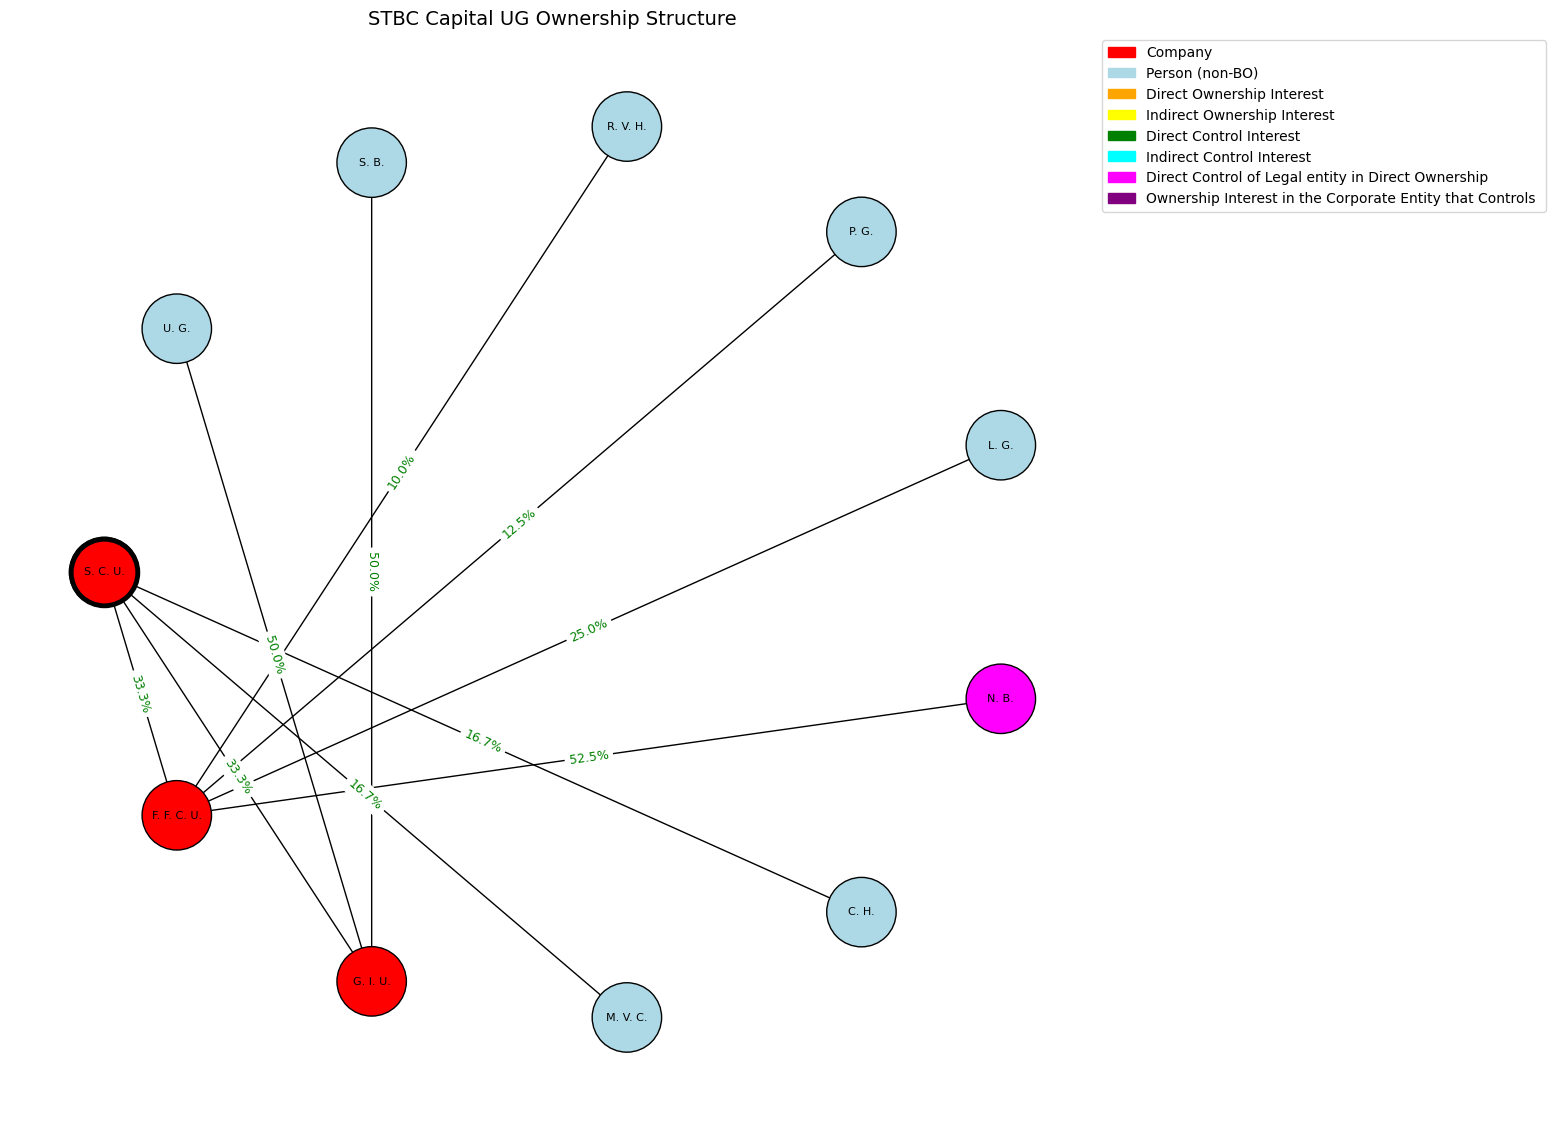

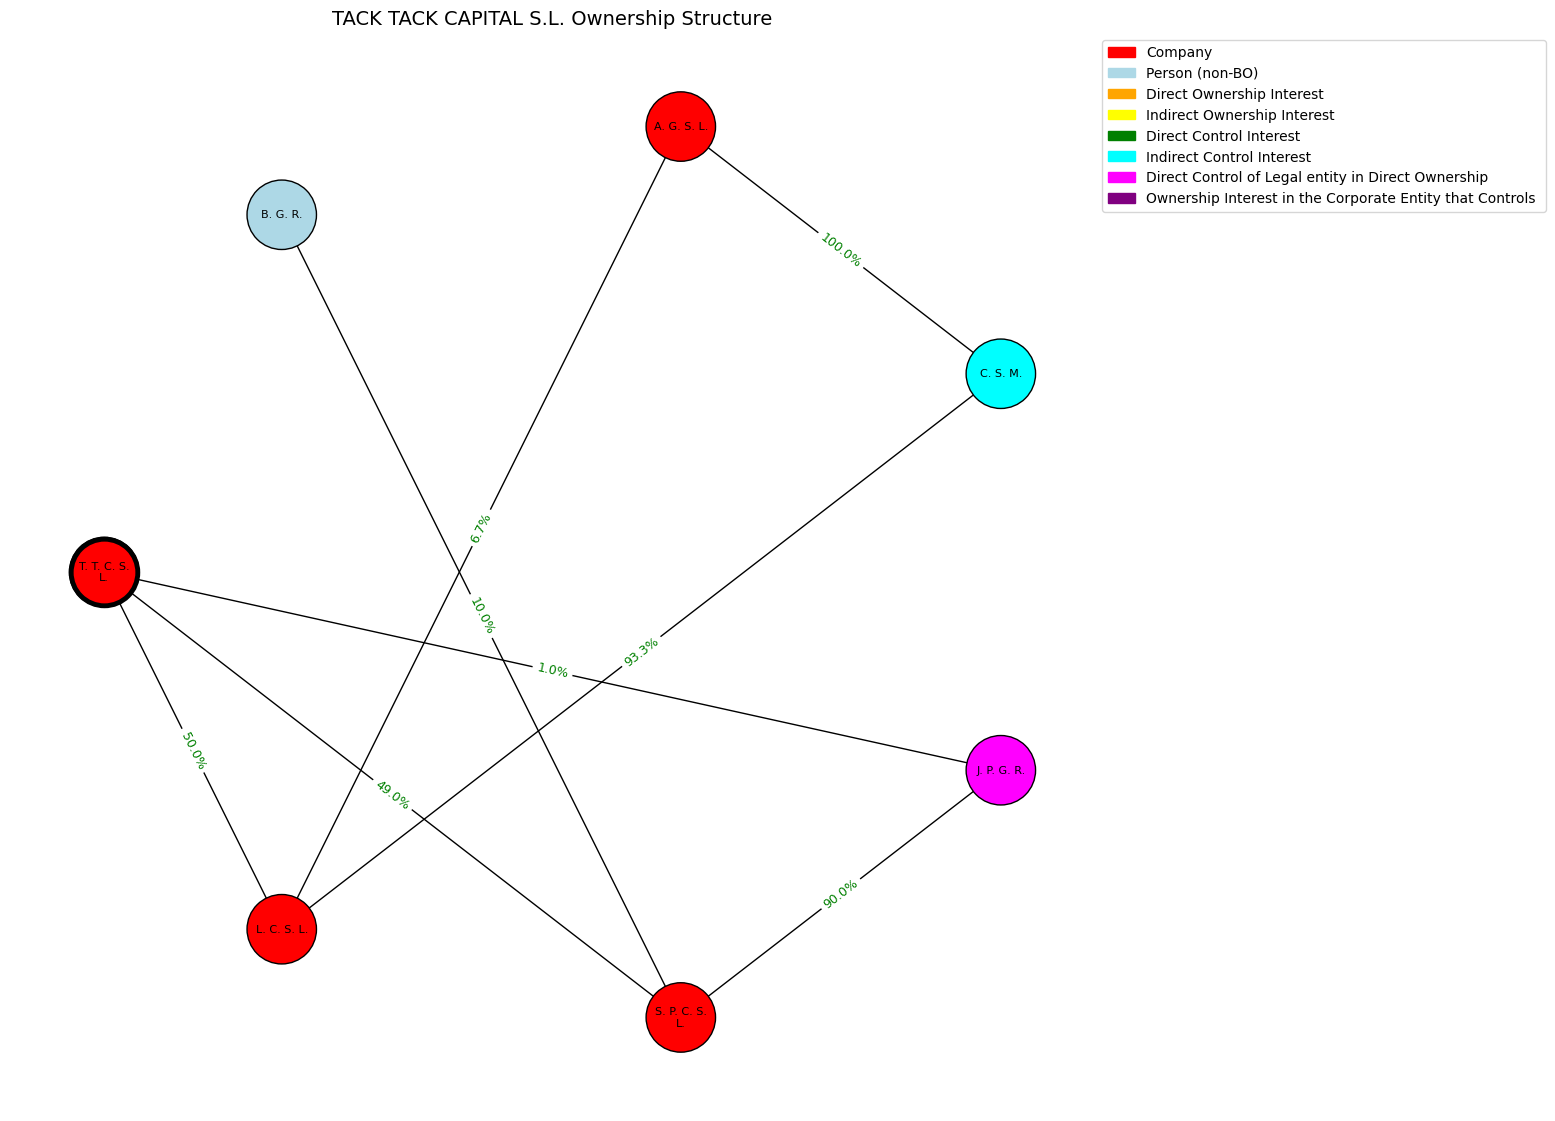

In [28]:
# Folder to save plots
output_folder = "plots_with_bo"
os.makedirs(output_folder, exist_ok=True)

# Loop through all company graphs
for i, G in enumerate(cgraph):
    company_name = G.nodes["u0"].get("name", f"Company {i}")
    
    # Assign BO_scenario for coloring
    for node, data in G.nodes(data=True):
        if data.get("node_type") != "person":
            continue
        scenario = data.get("scenario", None)
        if scenario in [1, 2, 3, 4, 5, 6]:
            data["BO_scenario"] = scenario
        else:
            data["BO_scenario"] = None

    # Save figure inside the draw function
    safe_name = company_name.replace("/", "_").replace("\\", "_")
    filename = os.path.join(output_folder, f"{safe_name}.png")
    
    draw_company_graph(
        G,
        title=company_name,
        node_size=2500,
        font_size=8,
        wrap_width=12,
        filename=filename  # pass filename for saving
    )
